# Results Section — EU vs US Cookie Consent Analysis

This notebook produces the figures and table values for the **Results** section of the paper. It compares cookie consent interfaces between EU and US traffic using Consent Observatory scraper data.

**Data sources**: `tranco_germany.json` (EU) and `tranco_usa.json` (US). Button categorization uses NormalizedWordButtonGatherer's numeric `category` field when available.

## 1. Setup and Data Loading

In [97]:
import json
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- Paths ---
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.data_loader import load_records_from_json_file
from src.utils import extract_domain_from_url

DATA_DIR = PROJECT_ROOT / 'data'
EXAMPLES_DIR = DATA_DIR / 'examples'
OUTPUT_DIR = DATA_DIR / 'output' / 'analysis'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# --- Plot style ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 10
COLORS = {'EU': '#003399', 'US': '#B22234'}

print("Setup complete.")

Setup complete.


In [98]:
# --- Load data ---
def has_analysis_data(record):
    """Keep only records with cookie or button data."""
    data = record.get('data', {}) or {}
    return 'CookieGatherer' in data or 'ButtonGatherer' in data

eu_records = load_records_from_json_file(EXAMPLES_DIR / 'tranco_germany.json')
eu_records = [r for r in eu_records if has_analysis_data(r)]

us_records = load_records_from_json_file(EXAMPLES_DIR / 'tranco_usa.json')
us_records = [r for r in us_records if has_analysis_data(r)]

print(f"EU records: {len(eu_records)}")
print(f"US records: {len(us_records)}")

# --- Inspect JSON structure (first record) ---
sample = eu_records[0] if eu_records else {}
print("\nTop-level keys:", list(sample.keys()))
print("data gatherers:", list((sample.get('data') or {}).keys()))

for gatherer in ['CookieGatherer', 'NormalizedWordButtonGatherer', 'CMPGatherer', 'CheckboxGatherer']:
    gatherer_data = (sample.get('data') or {}).get(gatherer, {})
    if not gatherer_data:
        continue
    if gatherer == 'CookieGatherer':
        cookies = gatherer_data.get('cookies', [])
        first = cookies[0] if cookies else {}
        print(f"  {gatherer} cookie keys: {list(first.keys())[:12]}")
    elif 'detectionsArray' in gatherer_data:
        arr = gatherer_data['detectionsArray']
        first = arr[0] if arr else {}
        print(f"  {gatherer} detection keys: {list(first.keys())}")
    elif gatherer == 'CMPGatherer' and gatherer_data.get('CMPs'):
        print(f"  CMPGatherer CMP keys: {list(gatherer_data['CMPs'][0].keys())}")

EU records: 780
US records: 770

Top-level keys: ['time', 'url', 'requestStrategy', 'data']
data gatherers: ['ScreenshotGatherer', 'DOMGatherer', 'CookieGatherer', 'WordBoxGatherer', 'IABJSGatherer', 'EventListenerGatherer', 'ButtonGatherer', 'NormalizedWordButtonGatherer', 'VisibilityAnalyzer', 'CheckboxGatherer', 'CMPGatherer']
  CookieGatherer cookie keys: ['name', 'value', 'domain', 'path', 'expires', 'size', 'httpOnly', 'secure', 'session', 'priority', 'sameParty', 'sourceScheme']
  NormalizedWordButtonGatherer detection keys: []
  CheckboxGatherer detection keys: []


## 2. JSON Schema (from Consent Observatory Gatherers)

Each record has `url`, `time`, `requestStrategy`, and `data` with gatherer outputs:

| Gatherer | Output structure | Key fields |
|----------|------------------|------------|
| **CookieGatherer** | `{ cookies: [...] }` | `name`, `domain`, `path`, `secure`, `httpOnly`, `session`, `sameSite`, `expires` |
| **NormalizedWordButtonGatherer** | `{ detections, detectionsArray }` | `text`, `normalized`, `category`, `distance`, `visibilityAnalysis`, `popup`, `element` |
| **ButtonGatherer** | `{ detections, detectionsArray }` | `text`, `html`, `visibilityAnalysis` |
| **CMPGatherer** | `{ CMPs: [...] }` | `CMP_name`, `matchedPattern`, `matchingElement`, `matchingAttribute`, `matchingValue` |
| **CheckboxGatherer** | `{ detections, detectionsArray }` | `status` (checked), `disabled`, `html` |
| **WordBoxGatherer** | `{ hits, detections }` | Consent interface detection |

**NormalizedWordButtonGatherer category** (numeric, from word-corpus):
- 0 = Privacy/other (filtered out) | 1 = Accept | 2 = Reject | 3 = Settings | 4 = Accept selection | 5 = Other | 8,9 = filtered

In [99]:
# --- NormalizedWordButtonGatherer categories (consent-observatory.eu/rules/Gatherers/NormalizedWordButtonGatherer.js) ---
NWB_ACCEPT, NWB_REJECT, NWB_SETTINGS, NWB_ACCEPT_SELECTION = 1, 2, 3, 4

def build_site_summary(records, region):
    """
    Build per-site summary from JSON gatherer data.
    Uses NormalizedWordButtonGatherer category only (no keyword fallback).
    Returns DataFrame with: region, url, domain, has_banner, reject_placement, cmp_name, etc.
    """
    rows = []
    for record in records:
        url = record.get('url', '')
        data = record.get('data', {}) or {}
        cookies = data.get('CookieGatherer', {}).get('cookies', [])
        buttons = data.get('ButtonGatherer', {}).get('detectionsArray', [])
        nwb_detections = data.get('NormalizedWordButtonGatherer', {}).get('detectionsArray', [])
        cmps = data.get('CMPGatherer', {}).get('CMPs', [])
        checkboxes = data.get('CheckboxGatherer', {}).get('detectionsArray', [])

        has_banner = len(buttons) > 0 or len(nwb_detections) > 0
        has_reject_on_first_layer = any(d.get('category') == NWB_REJECT for d in nwb_detections)
        has_settings = any(d.get('category') == NWB_SETTINGS for d in nwb_detections)
        has_accept = any(d.get('category') == NWB_ACCEPT for d in nwb_detections)
        has_accept_selection = any(d.get('category') == NWB_ACCEPT_SELECTION for d in nwb_detections)

        # Classify where reject option appears (first layer, secondary menu, or not at all)
        if has_reject_on_first_layer:
            reject_placement = 'First Layer'
        elif has_settings:
            reject_placement = 'Secondary Menu'
        elif has_banner:
            reject_placement = 'No Reject Option'
        else:
            reject_placement = 'No Banner'

        cmp_name = cmps[0].get('CMP_name', 'Custom / Unknown') if cmps else 'Custom / Unknown'
        pre_ticked_count = sum(1 for c in checkboxes if c.get('status') is True)

        rows.append({
            'region': region, 'url': url, 'domain': extract_domain_from_url(url),
            'accessed': True, 'has_banner': has_banner, 'reject_placement': reject_placement,
            'cmp_name': cmp_name, 'cookie_count': len(cookies),
            'button_count': len(buttons) or len(nwb_detections), 'nwb_count': len(nwb_detections),
            'has_accept': has_accept, 'has_reject': has_reject_on_first_layer, 'has_settings': has_settings,
            'has_accept_selection': has_accept_selection, 'checkbox_count': len(checkboxes),
            'pre_ticked_count': pre_ticked_count,
        })
    return pd.DataFrame(rows)

# Build site summaries for EU and US
df_eu = build_site_summary(eu_records, 'EU')
df_us = build_site_summary(us_records, 'US')

# Combined flat table for export
df_sites = pd.concat([df_eu, df_us], ignore_index=True)
df_sites.to_csv(OUTPUT_DIR / 'results_sites.csv', index=False)
print(f"Exported {len(df_sites)} site records to results_sites.csv")
df_sites.head(10)

Exported 1550 site records to results_sites.csv


,region,url,domain,accessed,has_banner,reject_placement,cmp_name,cookie_count,button_count,nwb_count,has_accept,has_reject,has_settings,has_accept_selection,checkbox_count,pre_ticked_count
0,EU,https://wikipedia.org,ikipedia.org,True,False,No Banner,Custom / Unknown,7,0,0,False,False,False,False,0,0
1,EU,https://google.com,google.com,True,False,No Banner,Custom / Unknown,4,0,0,False,False,False,False,0,0
2,EU,https://icloud.com,icloud.com,True,False,No Banner,Custom / Unknown,1,0,0,False,False,False,False,0,0
3,EU,https://github.com,github.com,True,False,No Banner,Custom / Unknown,6,0,0,False,False,False,False,0,0
4,EU,https://ntp.org,ntp.org,True,False,No Banner,Custom / Unknown,2,0,0,False,False,False,False,0,0
5,EU,https://instagram.com,instagram.com,True,True,First Layer,Custom / Unknown,1,2,3,False,True,False,False,0,0
6,EU,https://netflix.com,netflix.com,True,True,First Layer,OneTrust,5,3,3,True,True,True,False,0,0
7,EU,https://windows.net,indows.net,True,True,First Layer,Custom / Unknown,6,3,3,True,True,True,False,0,0
8,EU,https://twitter.com,twitter.com,True,True,First Layer,Custom / Unknown,7,3,3,True,True,True,False,0,0
9,EU,https://whatsapp.com,hatsapp.com,True,False,No Banner,Custom / Unknown,3,0,0,False,False,False,False,0,0


In [100]:
# --- Cookie-level table (all CookieGatherer properties) ---
def build_cookie_table(records, region):
    """Flatten CookieGatherer data into one row per cookie per site."""
    rows = []
    for record in records:
        url = r.get('url', '')
        site_domain = extract_domain_from_url(url)
        cookies = (record.get('data', {}) or {}).get('CookieGatherer', {}).get('cookies', [])
        for cookie in cookies:
            domain = (cookie.get('domain') or '').lower().lstrip('.')
            is_first_party = site_domain in domain or domain in site_domain
            rows.append({
                'region': region, 'url': url, 'name': cookie.get('name', ''),
                'domain': domain, 'path': cookie.get('path', ''), 'is_first_party': is_first_party,
                'secure': cookie.get('secure', False), 'httpOnly': cookie.get('httpOnly', False),
                'session': cookie.get('session', False), 'sameSite': cookie.get('sameSite', ''),
                'size': cookie.get('size', 0), 'expires': cookie.get('expires'),
            })
    return pd.DataFrame(rows)

df_cookies_eu = build_cookie_table(eu_records, 'EU')
df_cookies_us = build_cookie_table(us_records, 'US')
df_cookies = pd.concat([df_cookies_eu, df_cookies_us], ignore_index=True)
df_cookies.to_csv(OUTPUT_DIR / 'results_cookies.csv', index=False)
print(f"Exported {len(df_cookies)} cookie records to results_cookies.csv")

# --- Button-level table (NormalizedWordButtonGatherer: category, normalized, visibilityAnalysis) ---
CATEGORY_NAMES = {1: 'Accept', 2: 'Reject', 3: 'Settings', 4: 'Accept selection', 5: 'Other'}

def build_buttons_table(records, region):
    """Flatten NormalizedWordButtonGatherer detections into one row per button per site."""
    rows = []
    for record in records:
        url = record.get('url', '')
        detections = (record.get('data', {}) or {}).get('NormalizedWordButtonGatherer', {}).get('detectionsArray', [])
        for det in detections:
            visibility = det.get('visibilityAnalysis') or {}
            rows.append({
                'region': region, 'url': url, 'text': det.get('text', ''), 'normalized': det.get('normalized', ''),
                'category': det.get('category'), 'category_name': CATEGORY_NAMES.get(det.get('category'), 'Unknown'),
                'distance': det.get('distance'), 'popup': det.get('popup'),
                'visible': visibility.get('visible', True), 'score': visibility.get('score'),
                'x': visibility.get('x'), 'y': visibility.get('y'), 'width': visibility.get('width'), 'height': visibility.get('height'),
            })
    return pd.DataFrame(rows)

df_buttons = pd.concat([build_buttons_table(eu_records, 'EU'), build_buttons_table(us_records, 'US')], ignore_index=True)
df_buttons.to_csv(OUTPUT_DIR / 'results_buttons.csv', index=False)
print(f"Exported {len(df_buttons)} button records to results_buttons.csv")
df_buttons.head(10)

NameError: name 'r' is not defined

## 3. Results Section — Table Values and Figures

### 3.1 Data Collection and Accessible Sample (Table 1)

In [ ]:
# --- Table 1: Dataset attrition ---
INITIAL_TRANCO = 1000
eu_accessed = len(df_eu)
us_accessed = len(df_us)
common_urls = len(set(df_eu['url']) & set(df_us['url']))

eu_banner = df_eu['has_banner'].sum()
us_banner = df_us['has_banner'].sum()
eu_no_banner = eu_accessed - eu_banner
us_no_banner = us_accessed - us_banner

tab1 = pd.DataFrame({
    'Filtering Stage': [
        'Initial Tranco List (Top 1,000)',
        'Successfully Accessed',
        'Banner Detected (UI Base)',
        'No Banner (Tracking Base)',
    ],
    'EU': [INITIAL_TRANCO, eu_accessed, eu_banner, eu_no_banner],
    'US': [INITIAL_TRANCO, us_accessed, us_banner, us_no_banner],
})
print("Table 1: Dataset Attrition and Filtering")
print(tab1.to_string(index=False))
print(f"\nUsable sample (common URLs): {common_urls}")

Table 1: Dataset Attrition and Filtering
                Filtering Stage   EU   US
Initial Tranco List (Top 1,000) 1000 1000
          Successfully Accessed  780  770
      Banner Detected (UI Base)  440  268
      No Banner (Tracking Base)  340  502

Usable sample (common URLs): 744


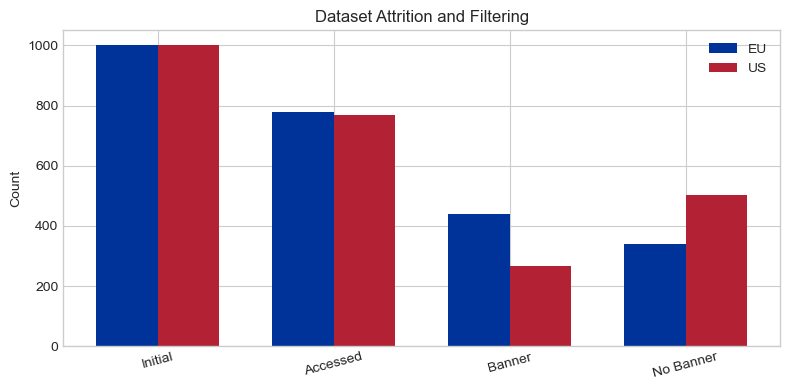

In [ ]:
# Figure: Dataset attrition
fig, ax = plt.subplots(figsize=(8, 4))
x = np.arange(4)
w = 0.35
ax.bar(x - w/2, tab1['EU'], w, label='EU', color=COLORS['EU'])
ax.bar(x + w/2, tab1['US'], w, label='US', color=COLORS['US'])
ax.set_xticks(x)
ax.set_xticklabels(['Initial', 'Accessed', 'Banner', 'No Banner'], rotation=15)
ax.set_ylabel('Count')
ax.set_title('Dataset Attrition and Filtering')
ax.legend()
ax.set_ylim(0, INITIAL_TRANCO + 50)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'results_attrition.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.2 Presence of Cookie Banners

In [ ]:
eu_pct_banner = 100 * eu_banner / eu_accessed if eu_accessed else 0
us_pct_banner = 100 * us_banner / us_accessed if us_accessed else 0

print(f"EU: {eu_pct_banner:.1f}% displayed a banner ({eu_banner}/{eu_accessed})")
print(f"US: {us_pct_banner:.1f}% displayed a banner ({us_banner}/{us_accessed})")

EU: 56.4% displayed a banner (440/780)
US: 34.8% displayed a banner (268/770)


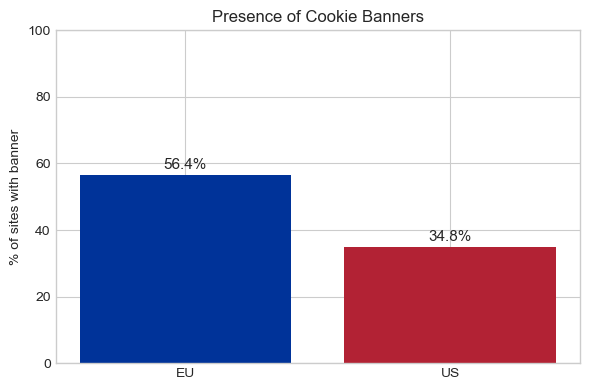

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(['EU', 'US'], [eu_pct_banner, us_pct_banner], color=[COLORS['EU'], COLORS['US']])
ax.set_ylabel('% of sites with banner')
ax.set_title('Presence of Cookie Banners')
ax.set_ylim(0, 100)
for i, v in enumerate([eu_pct_banner, us_pct_banner]):
    ax.text(i, v + 2, f'{v:.1f}%', ha='center', fontsize=11)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'results_banner_presence.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.3 First-Layer Reject All Buttons (Table 2)

In [ ]:
def reject_stats(df):
    """Count reject-placement categories among sites with a banner. Returns (n, first_layer, secondary, no_reject)."""
    with_banner = df[df['has_banner']]
    n = len(with_banner)
    if n == 0:
        return 0, 0, 0, 0
    first_layer = (with_banner['reject_placement'] == 'First Layer').sum()
    secondary = (with_banner['reject_placement'] == 'Secondary Menu').sum()
    no_reject = (with_banner['reject_placement'] == 'No Reject Option').sum()
    return n, first_layer, secondary, no_reject

n_eu_banner, first_layer_eu, secondary_eu, no_reject_eu = reject_stats(df_eu)
n_us_banner, first_layer_us, secondary_us, no_reject_us = reject_stats(df_us)

tab2 = pd.DataFrame({
    'Placement Category': ['First Layer', 'Secondary Menu', 'No Reject Option'],
    'EU (n=' + str(n_eu_banner) + ')': [f'{100*first_layer_eu/n_eu_banner:.1f}%' if n_eu_banner else '0%', f'{100*secondary_eu/n_eu_banner:.1f}%' if n_eu_banner else '0%', f'{100*no_reject_eu/n_eu_banner:.1f}%' if n_eu_banner else '0%'],
    'US (n=' + str(n_us_banner) + ')': [f'{100*first_layer_us/n_us_banner:.1f}%' if n_us_banner else '0%', f'{100*secondary_us/n_us_banner:.1f}%' if n_us_banner else '0%', f'{100*no_reject_us/n_us_banner:.1f}%' if n_us_banner else '0%'],
})
print("Table 2: Reject All Placement on Active Banners")
print(tab2.to_string(index=False))

Table 2: Reject All Placement on Active Banners
Placement Category EU (n=440) US (n=268)
       First Layer      62.7%      41.4%
    Secondary Menu      26.8%      37.3%
  No Reject Option      10.5%      21.3%


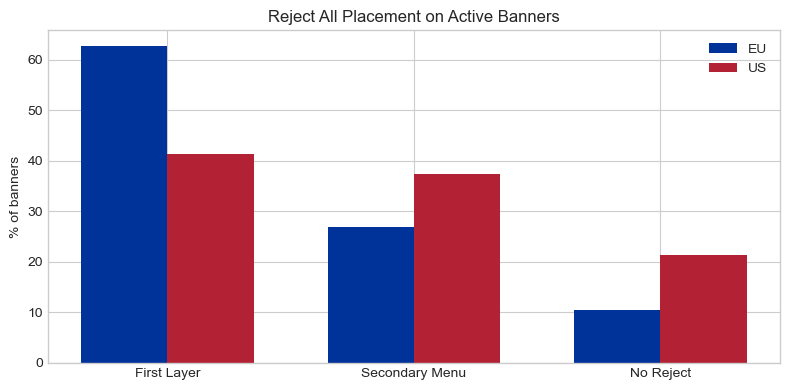

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
cats = ['First Layer', 'Secondary Menu', 'No Reject']
eu_vals = [100*first_layer_eu/n_eu_banner if n_eu_banner else 0, 100*secondary_eu/n_eu_banner if n_eu_banner else 0, 100*no_reject_eu/n_eu_banner if n_eu_banner else 0]
us_vals = [100*first_layer_us/n_us_banner if n_us_banner else 0, 100*secondary_us/n_us_banner if n_us_banner else 0, 100*no_reject_us/n_us_banner if n_us_banner else 0]
x = np.arange(3)
w = 0.35
ax.bar(x - w/2, eu_vals, w, label='EU', color=COLORS['EU'])
ax.bar(x + w/2, us_vals, w, label='US', color=COLORS['US'])
ax.set_xticks(x)
ax.set_xticklabels(cats)
ax.set_ylabel('% of banners')
ax.set_title("Reject All Placement on Active Banners")
ax.legend()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'results_reject_placement.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.4 Third-Party CMPs vs Custom Banners (Table 3)

In [ ]:
CMP_NAMES = ['OneTrust', 'Cookiebot', 'Quantcast', 'TrustArc', 'Custom / Unknown']

def cmp_stats(df):
    """Count CMP usage among sites with banner. Returns (dict of CMP->(count, pct), total)."""
    with_banner = df[df['has_banner']]
    total = len(with_banner)
    out = {}
    for name in CMP_NAMES:
        if name == 'Custom / Unknown':
            mask = ~with_banner['cmp_name'].str.lower().str.contains('onetrust|cookiebot|quantcast|trustarc', na=False, regex=True)
        else:
            mask = with_banner['cmp_name'].str.contains(name, case=False, na=False)
        cnt = mask.sum()
        pct = 100 * cnt / total if total else 0
        out[name] = (cnt, pct)
    return out, total

cmp_counts_eu, total_eu_banner = cmp_stats(df_eu)
cmp_counts_us, total_us_banner = cmp_stats(df_us)

tab3_data = []
for name in CMP_NAMES:
    count_eu, pct_eu = cmp_counts_eu[name]
    count_us, pct_us = cmp_counts_us[name]
    tot = count_eu + count_us  # approximate total found across both regions
    tab3_data.append({'Provider': name, 'Total Found': tot, 'EU': f'{pct_eu:.1f}%', 'US': f'{pct_us:.1f}%'})

tab3 = pd.DataFrame(tab3_data)
print("Table 3: First-Layer Reject by Banner Provider")
print(tab3.to_string(index=False))

Table 3: First-Layer Reject by Banner Provider
        Provider  Total Found    EU    US
        OneTrust          181 27.0% 23.1%
       Cookiebot            0  0.0%  0.0%
       Quantcast            0  0.0%  0.0%
        TrustArc           17  2.7%  1.9%
Custom / Unknown          510 70.2% 75.0%


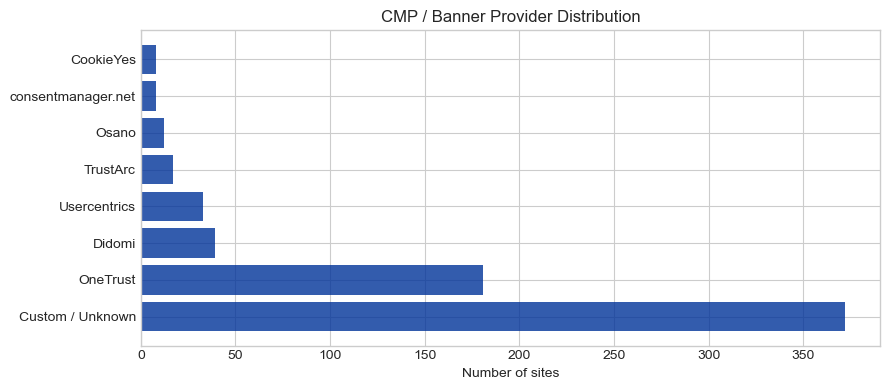

In [ ]:
# CMP bar chart (top providers by count)
cmp_counts = df_sites[df_sites['has_banner']].groupby('cmp_name').size().sort_values(ascending=False)
top_cmps = cmp_counts.head(8)
fig, ax = plt.subplots(figsize=(9, 4))
ax.barh(range(len(top_cmps)), top_cmps.values, color=COLORS['EU'], alpha=0.8)
ax.set_yticks(range(len(top_cmps)))
ax.set_yticklabels([n[:25] + ('...' if len(str(n)) > 25 else '') for n in top_cmps.index])
ax.set_xlabel('Number of sites')
ax.set_title('CMP / Banner Provider Distribution')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'results_cmp_breakdown.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.3b Button Category Distribution (NWB)

Number of **sites** (unique URLs) that have at least one button of each category. A site can have multiple buttons (e.g., "Accept All" and "Accept"), so we count sites, not total buttons.

Sites with at least one button of each category (unique URLs):
category_name  Accept  Reject  Settings  Accept selection  Other
region                                                          
EU                405     276       356                40      8
US                214     111       182                26      6


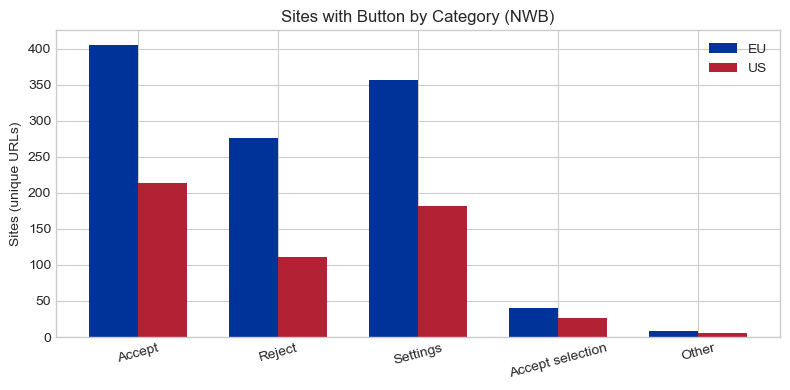

In [ ]:
# Button category distribution by region — count SITES (unique URLs) with each button type, not total buttons
cat_order = ['Accept', 'Reject', 'Settings', 'Accept selection', 'Other']
bt = df_buttons.groupby(['region', 'category_name'])['url'].nunique().unstack(fill_value=0)
for c in cat_order:
    if c not in bt.columns:
        bt[c] = 0
bt = bt[[c for c in cat_order if c in bt.columns]]
print("Sites with at least one button of each category (unique URLs):")
print(bt)
fig, ax = plt.subplots(figsize=(8, 4))
x = np.arange(len(bt.columns))
w = 0.35
eu_vals = bt.loc['EU'].values if 'EU' in bt.index else np.zeros(len(bt.columns))
us_vals = bt.loc['US'].values if 'US' in bt.index else np.zeros(len(bt.columns))
ax.bar(x - w/2, eu_vals, w, label='EU', color=COLORS['EU'])
ax.bar(x + w/2, us_vals, w, label='US', color=COLORS['US'])
ax.set_xticks(x)
ax.set_xticklabels(bt.columns, rotation=15)
ax.set_ylabel('Sites (unique URLs)')
ax.set_title('Sites with Button by Category (NWB)')
ax.legend()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'results_button_categories.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.5 Tracking Before Consent (Table 5)

In [ ]:
# Cookies set before consent = all cookies (scraper captures on load, before interaction)
# Use third-party cookies as proxy for tracking; or total cookie count buckets
def cookie_buckets(df):
    per_site = df['n_cookies']
    n0 = (per_site == 0).sum()
    n1_5 = ((per_site >= 1) & (per_site <=10)).sum()
    n6p = (per_site >= 11).sum()
    total = len(per_site)
    return total, 100*n0/total if total else 0, 100*n1_5/total if total else 0, 100*n6p/total if total else 0

def cookie_counts_by_region(df_cookies, df_sites):
    counts = df_cookies.groupby(['region', 'url']).size().reset_index(name='n_cookies')
    merged = df_sites[['region', 'url']].merge(counts, on=['region', 'url'], how='left')
    merged['n_cookies'] = merged['n_cookies'].fillna(0).astype(int)
    return merged

cc = cookie_counts_by_region(df_cookies, df_sites)
eu_cc = cc[cc['region'] == 'EU']
us_cc = cc[cc['region'] == 'US']

_, e0, e1, e11 = cookie_buckets(eu_cc)
_, u0, u1, u11 = cookie_buckets(us_cc)
ne, nu = len(eu_cc), len(us_cc)

tab5 = pd.DataFrame({
    'Tracking Cookies Set': ['0 (Compliant)', '1 to 10 cookies', '11 or more cookies'],
    'EU (n=' + str(ne) + ')': [f'{e0:.1f}%', f'{e1:.1f}%', f'{e11:.1f}%'],
    'US (n=' + str(nu) + ')': [f'{u0:.1f}%', f'{u1:.1f}%', f'{u11:.1f}%'],
})
print("Table 5: Cookies Set Before User Interaction")
print(tab5.to_string(index=False))

Table 5: Cookies Set Before User Interaction
Tracking Cookies Set EU (n=780) US (n=770)
       0 (Compliant)       6.5%       5.5%
     1 to 10 cookies      54.4%      43.5%
  11 or more cookies      39.1%      51.0%


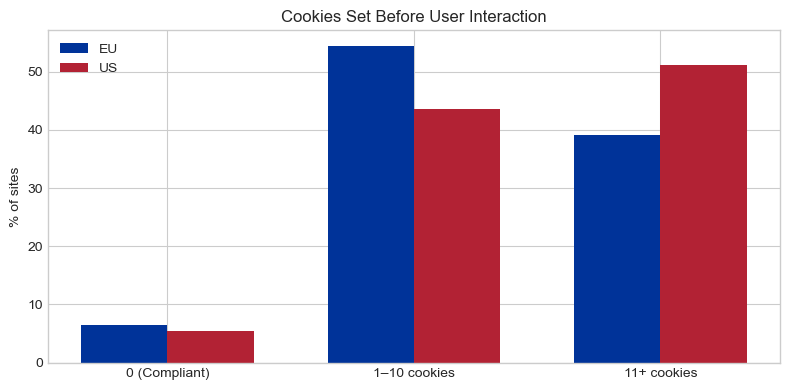

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
cats = ['0 (Compliant)', '1–10 cookies', '11+ cookies']
eu_vals = [e0, e1, e11]
us_vals = [u0, u1, u11]
x = np.arange(3)
w = 0.35
ax.bar(x - w/2, eu_vals, w, label='EU', color=COLORS['EU'])
ax.bar(x + w/2, us_vals, w, label='US', color=COLORS['US'])
ax.set_xticks(x)
ax.set_xticklabels(cats)
ax.set_ylabel('% of sites')
ax.set_title('Cookies Set Before User Interaction')
ax.legend()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'results_premature_tracking.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.6 Pre-Ticked Boxes (CheckboxGatherer)

Sites with checkboxes pre-ticked (`status: true`) before user interaction.

In [ ]:
# --- Pre-ticked checkboxes (CheckboxGatherer status=True) ---
# Among sites that have checkboxes, how many had at least one pre-ticked?
with_checkboxes_eu = df_eu[df_eu['checkbox_count'] > 0]
with_checkboxes_us = df_us[df_us['checkbox_count'] > 0]
pre_ticked_eu = (with_checkboxes_eu['pre_ticked_count'] > 0).sum()
pre_ticked_us = (with_checkboxes_us['pre_ticked_count'] > 0).sum()
n_cb_eu = len(with_checkboxes_eu)
n_cb_us = len(with_checkboxes_us)
pct_eu = 100 * pre_ticked_eu / n_cb_eu if n_cb_eu else 0
pct_us = 100 * pre_ticked_us / n_cb_us if n_cb_us else 0
print(f"EU: {pct_eu:.1f}% of sites with checkboxes had pre-ticked ({pre_ticked_eu}/{n_cb_eu})")
print(f"US: {pct_us:.1f}% of sites with checkboxes had pre-ticked ({pre_ticked_us}/{n_cb_us})")

EU: 66.7% of sites with checkboxes had pre-ticked (8/12)
US: 60.0% of sites with checkboxes had pre-ticked (6/10)


### 3.7 Silent Tracking (No Banner, Still Tracking)

Sites without a detected banner that still set cookies.

In [ ]:
# --- Silent tracking: sites with no banner that still set cookies ---
no_banner_eu = df_eu[~df_eu['has_banner']]
no_banner_us = df_us[~df_us['has_banner']]

def silent_pct(no_banner_df, df_cookies, region):
    """Among sites with no banner, count how many set cookies (silent tracking). Returns (n_tracked, pct)."""
    urls = set(no_banner_df['url'])
    if not urls:
        return 0, 0
    with_cookies = df_cookies[(df_cookies['region'] == region) & (df_cookies['url'].isin(urls))].groupby('url').size()
    n_tracked = (with_cookies > 0).sum()
    return n_tracked, 100 * n_tracked / len(urls)

n_silent_eu, pct_silent_eu = silent_pct(no_banner_eu, df_cookies, 'EU')
n_silent_us, pct_silent_us = silent_pct(no_banner_us, df_cookies, 'US')

print(f"EU: Of {len(no_banner_eu)} sites with no banner, {n_silent_eu} ({pct_silent_eu:.1f}%) set cookies (silent tracking)")
print(f"US: Of {len(no_banner_us)} sites with no banner, {n_silent_us} ({pct_silent_us:.1f}%) set cookies (silent tracking)")

EU: Of 340 sites with no banner, 296 (87.1%) set cookies (silent tracking)
US: Of 502 sites with no banner, 464 (92.4%) set cookies (silent tracking)


## 4. Summary — LaTeX Placeholders

In [ ]:
print("Copy these values into your LaTeX [XXX] placeholders:\n")
print(f"[XXX] accessible websites: {common_urls}")
print(f"[XXX] EU / [XXX] US successfully accessed: {eu_accessed} / {us_accessed}")
print(f"[XXX] EU / [XXX] US banner detected: {eu_banner} / {us_banner}")
print(f"[XXX] EU / [XXX] US no banner: {eu_no_banner} / {us_no_banner}")
print(f"[XX]% EU banner: {eu_pct_banner:.1f}")
print(f"[XX]% US banner: {us_pct_banner:.1f}")
print(f"[XX]% EU first-layer reject: {100*first_layer_eu/n_eu_banner:.1f}" if n_eu_banner else "N/A")
print(f"[XX]% US first-layer reject: {100*first_layer_us/n_us_banner:.1f}" if n_us_banner else "N/A")
print(f"Pre-ticked EU: {pct_eu:.1f}% ({pre_ticked_eu}/{n_cb_eu} sites with checkboxes)")
print(f"Pre-ticked US: {pct_us:.1f}% ({pre_ticked_us}/{n_cb_us} sites with checkboxes)")
print(f"Silent tracking US: {pct_silent_us:.1f}%")
print(f"Silent tracking EU: {pct_silent_eu:.1f}%")

Copy these values into your LaTeX [XXX] placeholders:

[XXX] accessible websites: 744
[XXX] EU / [XXX] US successfully accessed: 780 / 770
[XXX] EU / [XXX] US banner detected: 440 / 268
[XXX] EU / [XXX] US no banner: 340 / 502
[XX]% EU banner: 56.4
[XX]% US banner: 34.8
[XX]% EU first-layer reject: 62.7
[XX]% US first-layer reject: 41.4
Pre-ticked EU: 66.7% (8/12 sites with checkboxes)
Pre-ticked US: 60.0% (6/10 sites with checkboxes)
Silent tracking US: 92.4%
Silent tracking EU: 87.1%
